***
# NBA Game Prediction Models ⛹
Authors:
* Parth Shukla
* Matthew Saxsma

Date:
* 04-01-2025

***
## __Libraries__

In [ ]:
import pandas as pd
import os
import numpy as np
import pandas as pda
import missingno as msno
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# __Path__

In [39]:
# Notbook path
notebook_directory = os.getcwd()
print(f'Current notebook directory: {notebook_directory}')

Current notebook directory: c:\Users\Matth\Desktop\repos\CollabProject


# __Dataset 1__: `TeamStatistics.csv`
* Data from all NBA games.
* From 1946.

In [40]:
# dataset - https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores/
games_big_data_path = os.path.join(notebook_directory,'data','TeamStatistics.csv')
df_games_big = pd.read_csv(games_big_data_path)
np.shape(df_games_big)

(142836, 48)

In [41]:
df_games_big.sample(7) # quick look at the data

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,leadChanges,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses,coachId
107254,28100895,1982-04-11 20:00:00,Golden State,Warriors,1610612744,Portland,Trail Blazers,1610612757,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118262,27600196,1976-11-28 19:00:00,Indiana,Pacers,1610612754,Portland,Trail Blazers,1610612757,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131885,26600100,1966-11-26 19:00:00,San Francisco,Warriors,1610612744,Chicago,Bulls,1610612741,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91380,28900689,1990-02-20 20:00:00,Portland,Trail Blazers,1610612757,Charlotte,Hornets,1610612766,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128018,26900448,1970-02-18 19:00:00,San Diego,Rockets,1610612745,Seattle,SuperSonics,1610612760,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117885,27600381,1977-01-05 19:00:00,Philadelphia,76ers,1610612755,Los Angeles,Lakers,1610612747,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65814,20000558,2001-01-17 22:30:00,Phoenix,Suns,1610612756,Seattle,SuperSonics,1610612760,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_games_big.coachId.unique() # nothing in coach id column. We'll get rid of it.
df_games_big = df_games_big.drop(columns=['coachId'])

In [43]:
# checking what is redundant across rows of same game
df_games_big.loc[2240:2241,].T # we should check for NaNs

,2240,2241
gameId,22301095,22301095
gameDate,2024-04-02 19:00:00,2024-04-02 19:00:00
teamCity,Milwaukee,Washington
teamName,Bucks,Wizards
teamId,1610612749,1610612764
opponentTeamCity,Washington,Milwaukee
opponentTeamName,Wizards,Bucks
opponentTeamId,1610612764,1610612749
home,0,1
win,0,1


Missingness of df_teams

In [44]:
# missing percentage per column
cols_without_missing = []
for col in df_games_big.columns:
    missing_percent = df_games_big[col].isna().sum()/len(df_games_big)
    if missing_percent > 0.30: # if more than 30% of the column is missing, we want to drop it
        cols_without_missing.append(False)
    else: 
        cols_without_missing.append(True)

# removing the columns with too many missing values
df_games_big = df_games_big[df_games_big.columns[cols_without_missing]]

# __Dataset 2__: `Games.csv`
* This data also contains information on every NBA game. 
* Each row is a game, which specifies the home and away teams
* This is different than the previous dataset, which has two rows for each game.

In [45]:
games_small_data_path = os.path.join(notebook_directory,'data','Games.csv')
df_games_small = pd.read_csv(games_small_data_path)
np.shape(df_games_small)

C:\Users\Matth\AppData\Local\Temp\ipykernel_11540\4217729876.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_games_small = pd.read_csv(games_small_data_path)


(71418, 17)

In [46]:
df_games_small.sample(7)

,gameId,gameDate,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,winner,gameType,attendance,arenaId,gameLabel,gameSubLabel,seriesGameNumber
47876,28700612,1988-02-27 20:00:00,Seattle,SuperSonics,1610612760,Golden State,Warriors,1610612744,114,111,1610612760,Regular Season,10752.0,72,NaN,NaN,NaN
21423,20801228,2009-04-15 22:30:00,Los Angeles,Clippers,1610612746,Oklahoma City,Thunder,1610612760,85,126,1610612760,Regular Season,19060.0,137,NaN,NaN,NaN
13897,21400537,2015-01-08 22:30:00,Portland,Trail Blazers,1610612757,Miami,Heat,1610612748,99,83,1610612757,Regular Season,19441.0,51,NaN,NaN,NaN
7334,21900142,2019-11-11 20:00:00,New Orleans,Pelicans,1610612740,Houston,Rockets,1610612745,116,122,1610612745,Regular Season,16695.0,160,NaN,NaN,NaN
33580,29901149,2000-04-15 20:30:00,San Antonio,Spurs,1610612759,Utah,Jazz,1610612762,106,83,1610612759,Regular Season,28114.0,1,NaN,NaN,NaN
1574,22300638,2024-01-26 20:00:00,Memphis,Grizzlies,1610612763,Orlando,Magic,1610612753,107,106,1610612763,Regular Season,16823.0,242,NaN,NaN,NaN
60073,27500044,1975-11-04 20:00:00,Milwaukee,Bucks,1610612749,Detroit,Pistons,1610612765,103,101,1610612749,Regular Season,8875.0,0,NaN,NaN,NaN


# Consolidating Datasets 1 and 2
* Dataset 1: `TeamStatistics.csv` has 142,836 rows, 2 per game
* Dataset 2: `Games.csv` has 71,418 rows, 1 per game

In [47]:
# both datasets with games have a game ID and a game date
print(f"Shared columns:\n\n\t{df_games_small.columns[df_games_small.columns.isin(df_games_big.columns)]}\n\n") 

# columns of df_games_big NOT in df_games
print(f"Columns of big df not in smaller:\n\n\t{df_games_big.columns[~df_games_big.columns.isin(df_games_small.columns)]}\n\n")

 # columns of df_games NOT in df_games_big
print(f"Columns of small df not in big:\n\n\t{df_games_small.columns[~df_games_small.columns.isin(df_games_big.columns)]}\n\n")

Shared columns:

	Index(['gameId', 'gameDate'], dtype='object')


Columns of big df not in smaller:

	Index(['teamCity', 'teamName', 'teamId', 'opponentTeamCity',
       'opponentTeamName', 'opponentTeamId', 'home', 'win', 'teamScore',
       'opponentScore', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted',
       'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersAttempted',
       'threePointersMade', 'threePointersPercentage', 'freeThrowsAttempted',
       'freeThrowsMade', 'freeThrowsPercentage', 'reboundsDefensive',
       'reboundsOffensive', 'reboundsTotal', 'foulsPersonal', 'turnovers',
       'plusMinusPoints', 'numMinutes'],
      dtype='object')


Columns of small df not in big:

	Index(['hometeamCity', 'hometeamName', 'hometeamId', 'awayteamCity',
       'awayteamName', 'awayteamId', 'homeScore', 'awayScore', 'winner',
       'gameType', 'attendance', 'arenaId', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber'],
      dtype='object')




In [48]:
# subsetting by home teams
df_games_big_home = df_games_big[df_games_big.home == 1]
print(f"Home teams data size: {df_games_big_home.shape}")

# subsetting by away teams
df_games_big_away = df_games_big[df_games_big.home == 0]
print(f"Away teams data size: {df_games_big_away.shape}")

# merging home and away teams dataframes
df_games_wide = df_games_big_home.merge(right=df_games_big_away,how='inner',on='gameId',suffixes=('_home','_away'))
print(f"Combined home and away data size: {df_games_wide.shape}")


Home teams data size: (71418, 31)
Away teams data size: (71418, 31)
Combined home and away data size: (71418, 61)


In [49]:
# merging df_games and home and away teams (df_games_wide) dataframes to make one big df_games dataframe
df_games = df_games_small.merge(right=df_games_wide, how='inner',on='gameId',suffixes=('_small','_wide'))
print(f"Combined data size: {df_games.shape}")
df_games.sample(5) # quick look at the data

Combined data size: (71418, 77)


,gameId,gameDate,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,...,freeThrowsAttempted_away,freeThrowsMade_away,freeThrowsPercentage_away,reboundsDefensive_away,reboundsOffensive_away,reboundsTotal_away,foulsPersonal_away,turnovers_away,plusMinusPoints_away,numMinutes_away
33992,29900741,2000-02-19 15:30:00,Utah,Jazz,1610612762,Detroit,Pistons,1610612765,91,87,...,21.0,19.0,0.905,29.0,8.0,37.0,24.0,14.0,-4.0,240.0
25418,20600059,2006-11-08 19:00:00,Washington,Wizards,1610612764,Indiana,Pacers,1610612754,117,91,...,31.0,23.0,0.742,30.0,19.0,49.0,22.0,25.0,-26.0,240.0
54091,28100435,1982-01-19 20:00:00,Houston,Rockets,1610612745,Kansas City,Kings,1610612758,120,112,...,28.0,23.0,0.821,NaN,NaN,NaN,21.0,NaN,-8.0,240.0
51935,28300607,1984-02-18 20:00:00,Cleveland,Cavaliers,1610612739,Indiana,Pacers,1610612754,93,118,...,32.0,28.0,0.875,NaN,NaN,45.0,30.0,NaN,25.0,240.0
52686,28200839,1983-04-01 20:00:00,Los Angeles,Lakers,1610612747,New York,Knicks,1610612752,102,88,...,24.0,16.0,0.667,NaN,NaN,44.0,18.0,NaN,-14.0,240.0


# Cleaning the combined dataset
Need to remove:
> 1. Columns that do not add information
> 2. Columns that are mostly empty
> 3. Rows that are mostly empty

Variable types:
> 1. One-hot encode all categorical variables
> 2. Make sure all numerical types are adequate


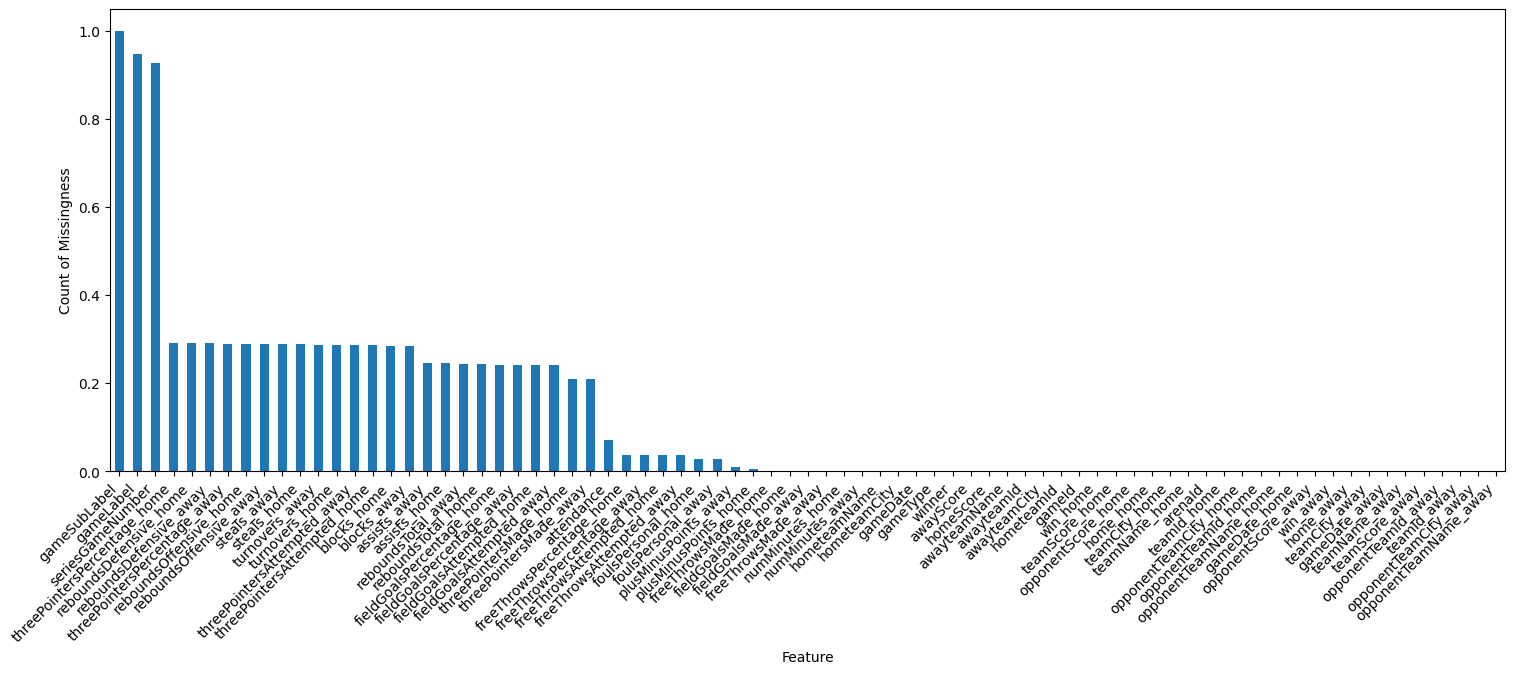

In [50]:
# missingness bar chart
plt.figure(figsize=(18,6))
missing_per_column = df_games.isna().sum().sort_values(ascending=False) / len(df_games)
missing_per_column.plot(kind='bar', xlabel='Feature',ylabel='Count of Missingness')
plt.xticks(rotation=45,ha='right',fontsize=10)
plt.show()


In [51]:
# relabeling winner Id (doesn't matter if we use home or away names)
df_games['winner']
df_games['hometeamName']
team_id_dict = dict(zip(df_games['hometeamId'].unique(),df_games['hometeamName'].unique()))
df_games['winner'] = df_games['winner'].map(team_id_dict)

In [52]:
# print(df_games.columns.tolist())
# columns that are superfluous or otherwise unneeded
unnecessary = [
    'arenaId',
    "hometeamCity",
    "awayteamCity",
    "hometeamId",
    "awayteamCity",
    "awayteamId",
    "gameDate_home",
    "teamCity_home",
    "teamName_home",
    "teamId_home",
    "opponentTeamCity_home",
    "opponentTeamName_home",
    "opponentTeamId_home",
    "home_home",
    "teamScore_home",
    "opponentScore_home",
    "numMinutes_home",
    "gameDate_away",
    "teamCity_away",
    "teamName_away",
    "teamId_away",
    "opponentTeamCity_away",
    "opponentTeamName_away",
    "opponentTeamId_away",
    "home_away",
    "win_away",
    "teamScore_away",
    "opponentScore_away",
    "numMinutes_away",
]

mostly_missing = ["gameLabel", "gameSubLabel", "seriesGameNumber"]

# changing gameDate to a datetime object
df_games["gameDate"] = pd.to_datetime(df_games["gameDate"])

In [53]:
# dropping the unnecessary columns
df_games.drop(columns=unnecessary,inplace=True)
 
 # dropping the mostly missing columns
df_games.drop(columns=mostly_missing,inplace=True)

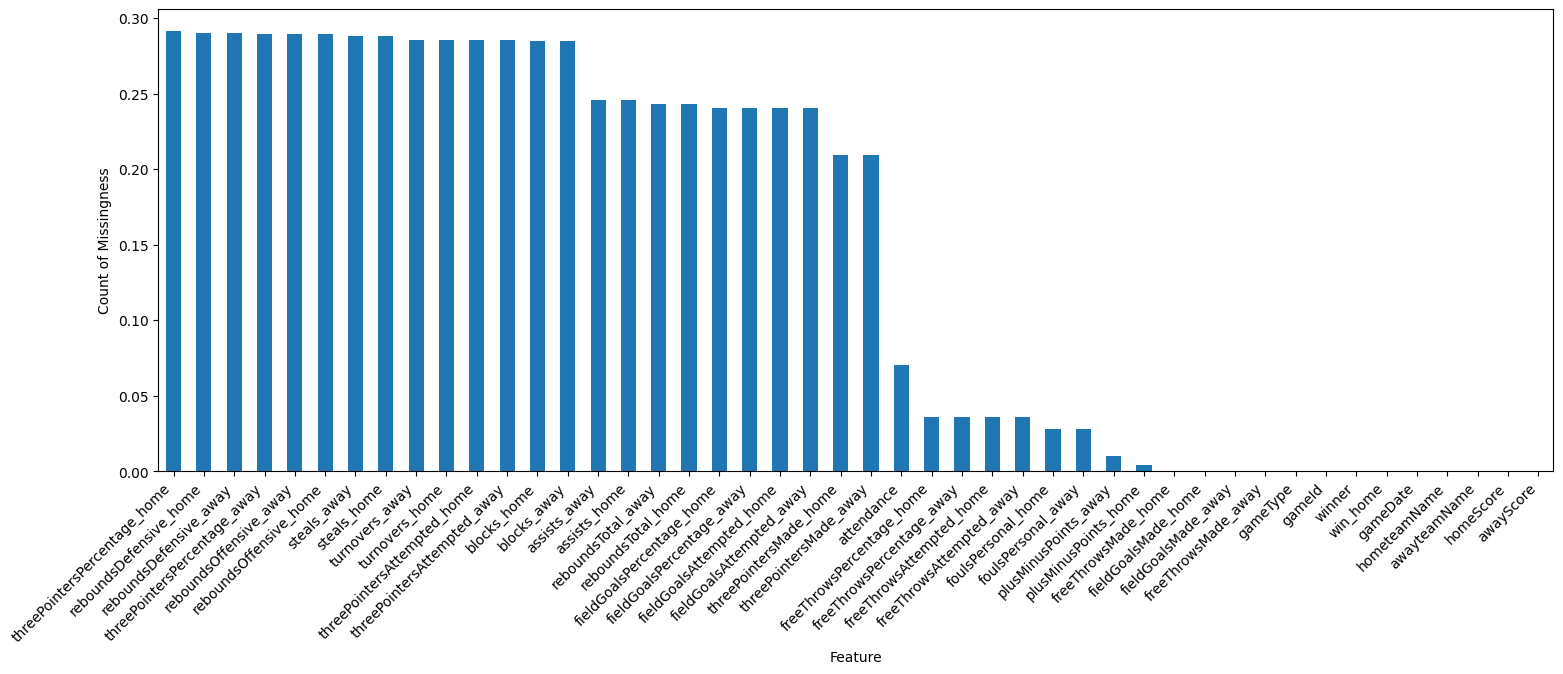

In [54]:
# check missingness bar chart again
# missingness still around 30% for several columns
plt.figure(figsize=(18,6))
missing_per_column = df_games.isna().sum().sort_values(ascending=False) / len(df_games)
missing_per_column.plot(kind='bar', xlabel='Feature',ylabel='Count of Missingness')
plt.xticks(rotation=45,ha='right',fontsize=10)
plt.show()

<Figure size 1000x100 with 0 Axes>

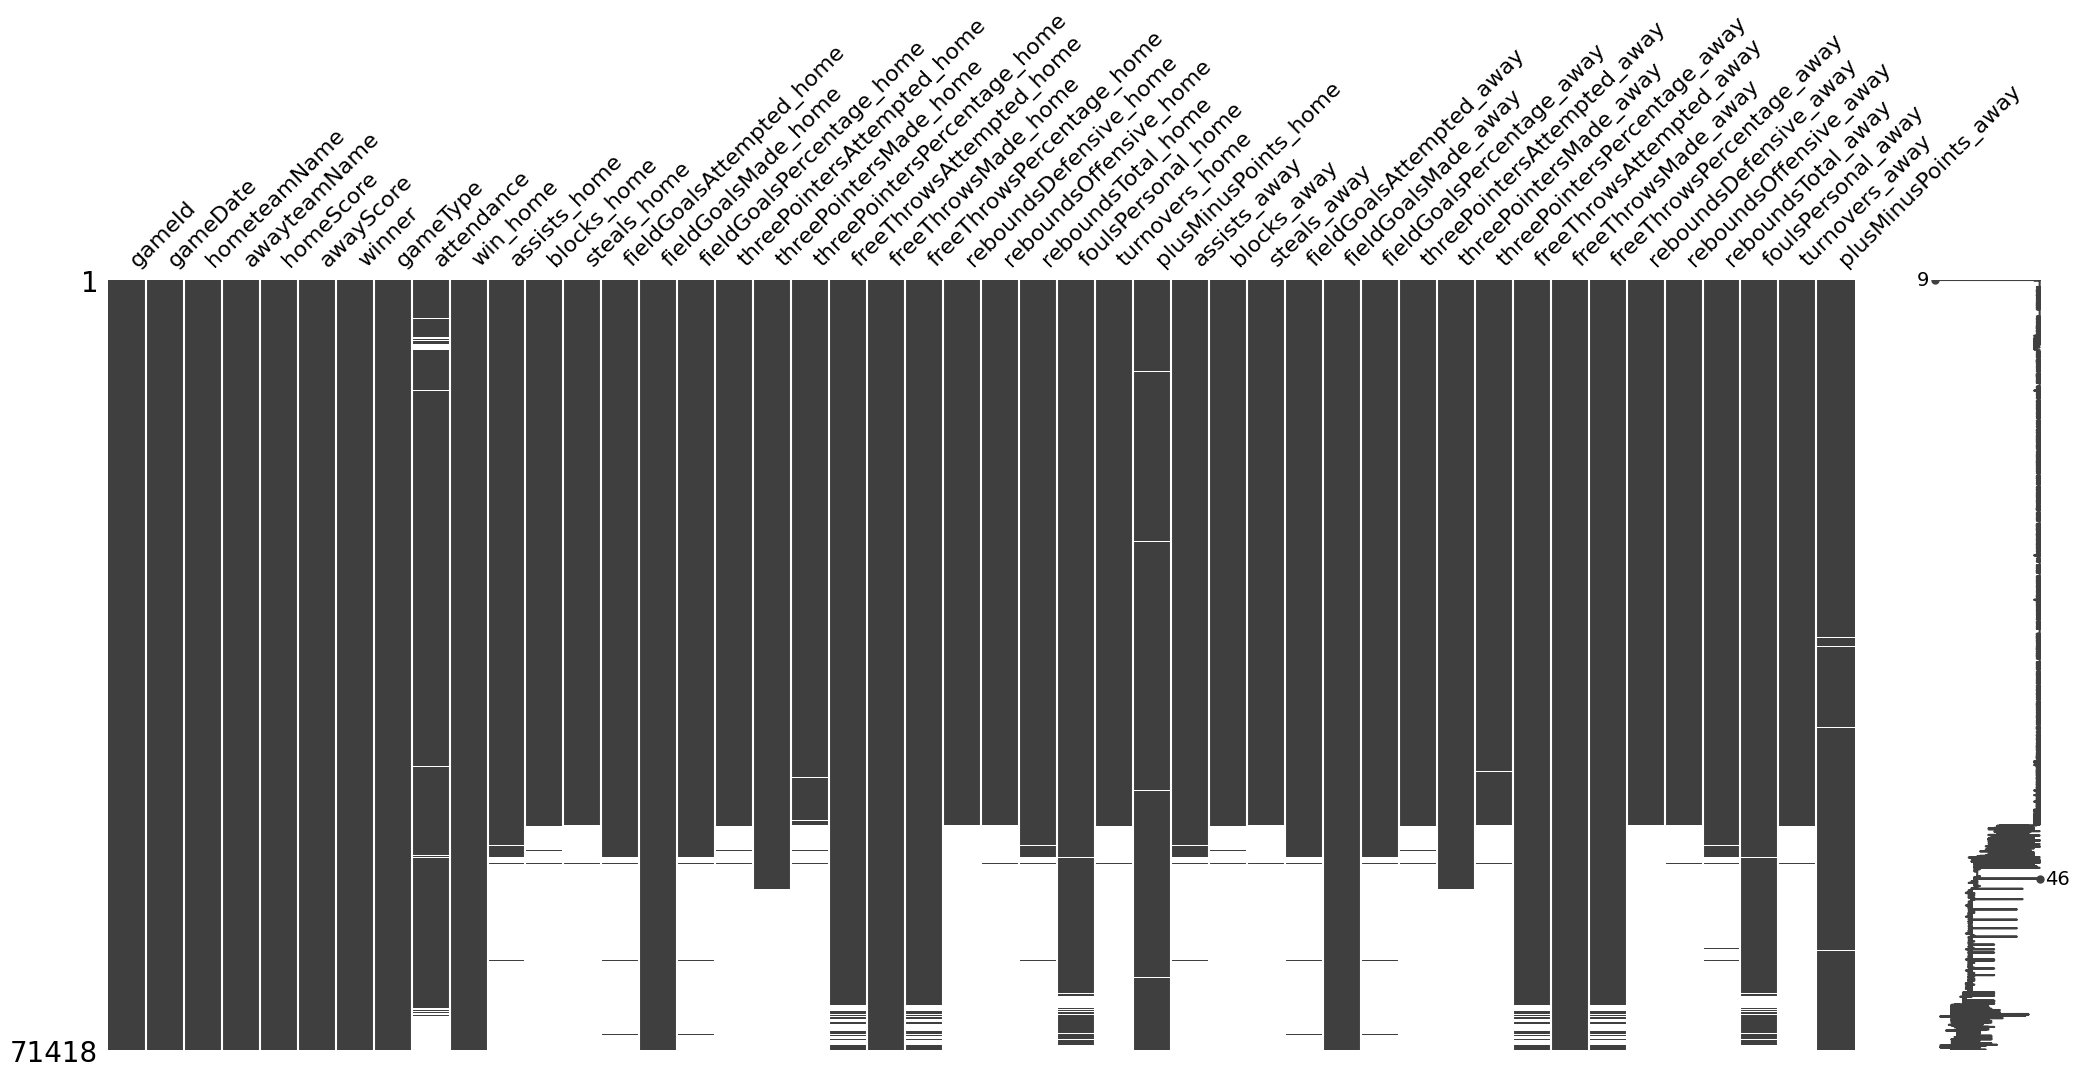

In [55]:
# missingness matrix to determine what rows might have lots of missingness
plt.figure(figsize=(10,1))
msno.matrix(df_games)
plt.show()

In [56]:
# I wrote this for loop to figure out where the rows start to have a lot of missing data
# for i in range(50575,50600):
#     print(f"Index {i}: {df_games.iloc[i].isna().sum() / df_games.shape[1]}")
print(len(df_games.iloc[0:50581])) # need to include 50,580 and exclude 50,581
print(df_games.iloc[50580].isna().sum() / df_games.shape[1])

50581
0.021739130434782608


In [57]:
# removing the largely missing rows
df_games = df_games.iloc[0:50581]
df_games.sample(4)

,gameId,gameDate,hometeamName,awayteamName,homeScore,awayScore,winner,gameType,attendance,win_home,...,threePointersPercentage_away,freeThrowsAttempted_away,freeThrowsMade_away,freeThrowsPercentage_away,reboundsDefensive_away,reboundsOffensive_away,reboundsTotal_away,foulsPersonal_away,turnovers_away,plusMinusPoints_away
17186,21200097,2012-11-12 19:30:00,Pistons,Thunder,90,92,Thunder,Regular Season,12784.0,0,...,0.100,42.0,37.0,0.881,35.0,9.0,44.0,20.0,14.0,2.0
31871,20100333,2001-12-16 19:00:00,Knicks,Nets,96,114,Nets,Regular Season,19763.0,0,...,0.583,29.0,24.0,0.828,31.0,6.0,37.0,27.0,18.0,18.0
14084,21400348,2014-12-14 18:00:00,Pelicans,Warriors,122,128,Warriors,Regular Season,15037.0,0,...,0.458,35.0,29.0,0.829,38.0,8.0,46.0,19.0,20.0,6.0
35888,29700893,1998-03-11 19:30:00,Cavaliers,Bucks,95,83,Cavaliers,Regular Season,14294.0,1,...,0.167,32.0,26.0,0.813,21.0,11.0,32.0,20.0,19.0,-12.0


<Figure size 1000x100 with 0 Axes>

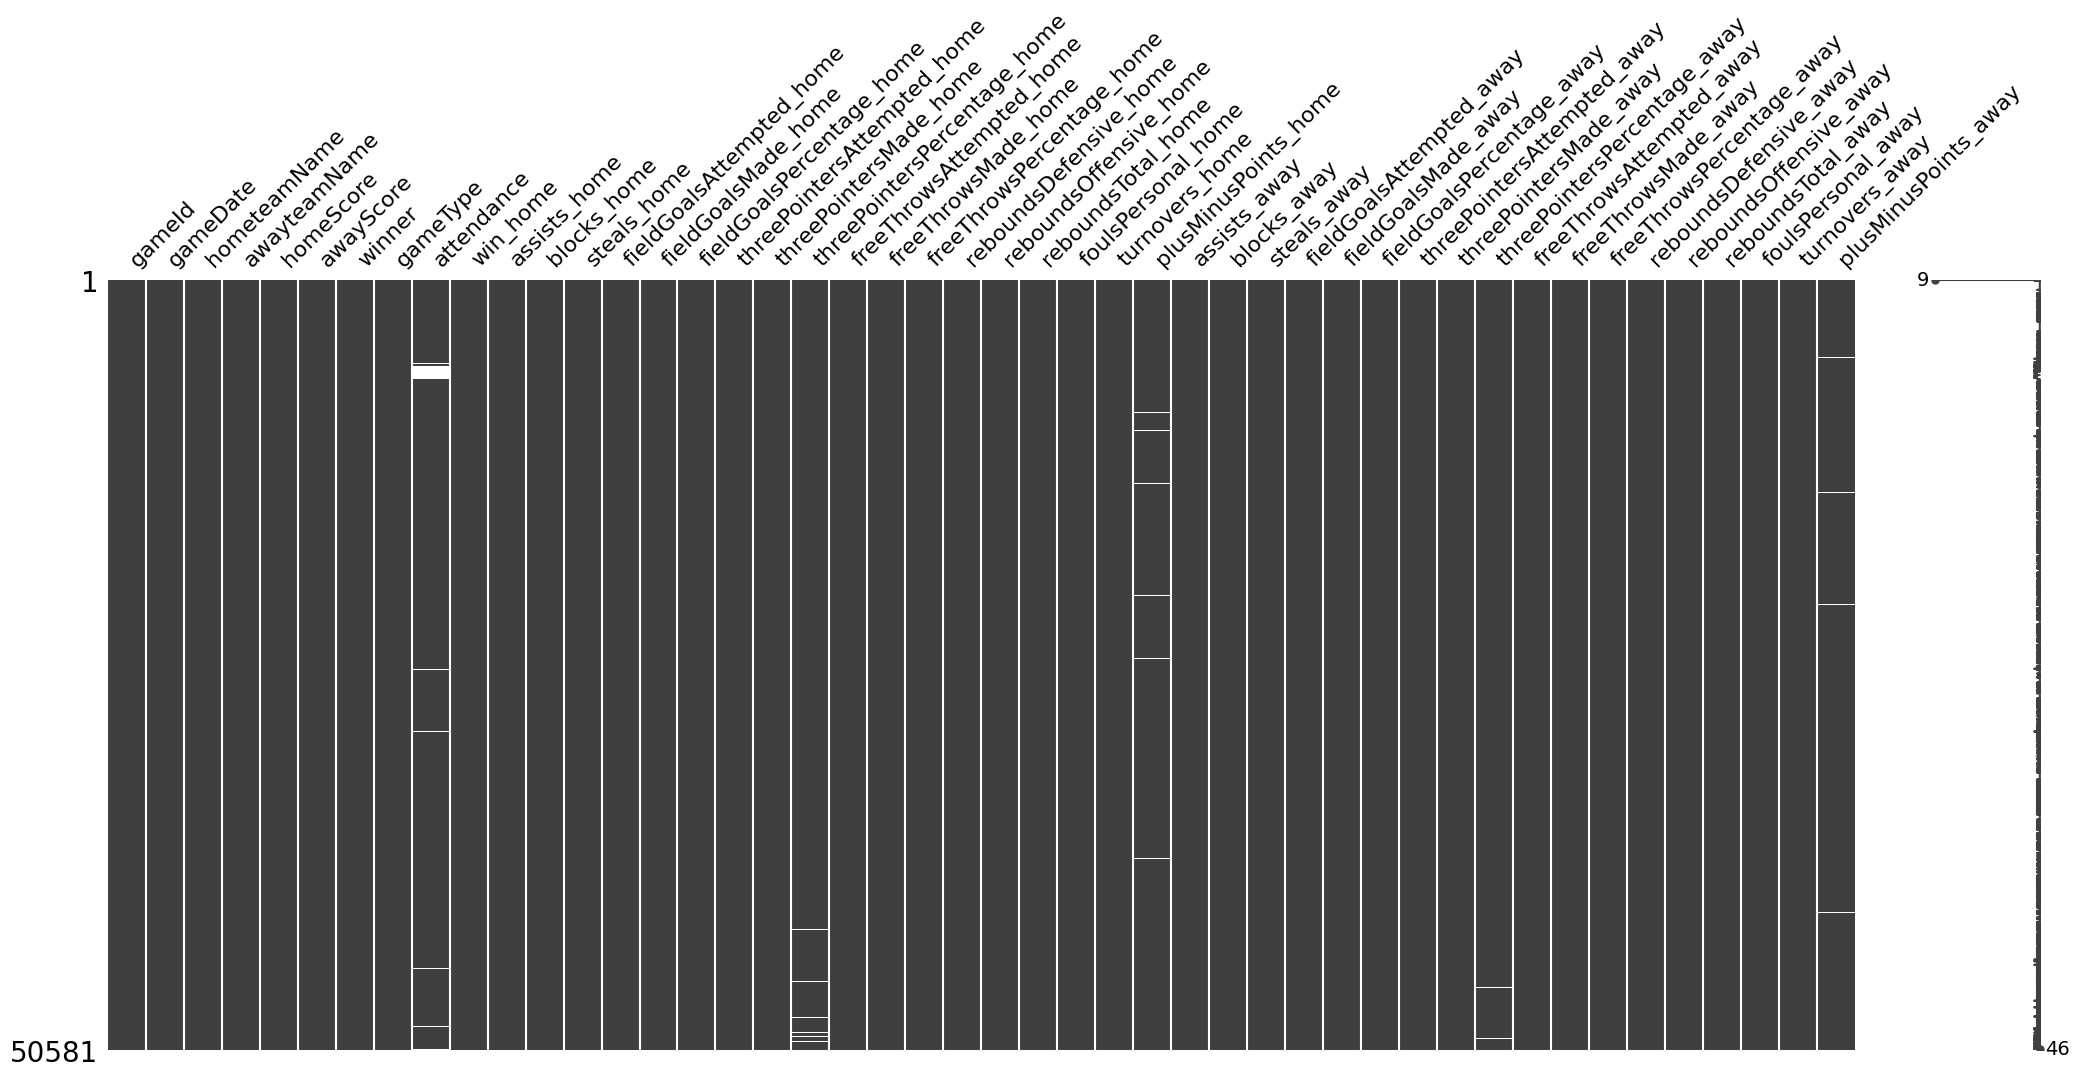

In [58]:
# checking the missingness matrix again to see if the row missingness looks better
# it does look solid
plt.figure(figsize=(10,1))
msno.matrix(df_games)
plt.show()

In [59]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50581 entries, 0 to 50580
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   gameId                        50581 non-null  int64         
 1   gameDate                      50581 non-null  datetime64[ns]
 2   hometeamName                  50581 non-null  object        
 3   awayteamName                  50581 non-null  object        
 4   homeScore                     50581 non-null  int64         
 5   awayScore                     50581 non-null  int64         
 6   winner                        50581 non-null  object        
 7   gameType                      50581 non-null  object        
 8   attendance                    49395 non-null  float64       
 9   win_home                      50581 non-null  int64         
 10  assists_home                  50580 non-null  float64       
 11  blocks_home                 

# __(Eventual denoising) Autoencoder__

### __Step 1.__ Prepare training data
1. We need to make sure all categorical varialbes are one-hot encoded.
2. Then 'mask' values (replace with 0s?) in corrupted training
3. Add normal/poisson noise to continuous variables (depending on scale)
4. Drop unneeded variables

In [60]:
df_games.drop(columns=['gameId','gameDate'],inplace=True)

Imputation

In [61]:
# Impute missing values with the mean for numerical columns
for col in df_games.columns:
    if df_games[col].isna().sum() > 0:  # Check if the column has missing values
        if df_games[col].dtype in ['float64', 'int64']:  # Only for numerical columns
            df_games[col].fillna(df_games[col].median(), inplace=True)
        if df_games[col].dtype == 'object':
            df_games[col].fillna('Missing', inplace=True)

C:\Users\Matth\AppData\Local\Temp\ipykernel_11540\3076076711.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_games[col].fillna(df_games[col].median(), inplace=True)
C:\Users\Matth\AppData\Local\Temp\ipykernel_11540\3076076711.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [62]:
# should show NO columns after imputation
for col in df_games.columns:
    if df_games[col].isna().sum() > 0:  # Check if the column has missing values
        print(f"Column {col} still has missing values after imputation.")

Turning `winner` into a PyTorch tensor

In [63]:
# creating team to index mapping for use with home team, away team, and winner one-hot encoded feaures
unique_teams = df_games['hometeamName'].unique()
team_to_index = {team: idx for idx, team in enumerate(unique_teams)}
labels_winner = torch.tensor(df_games['winner'].map(team_to_index).values)
one_hot_winner = F.one_hot(labels_winner,num_classes=len(unique_teams)).float()
print(f"One hot winner shape: {one_hot_winner.shape}")
one_hot_winner
# 33 features for 33 unique teams

One hot winner shape: torch.Size([50581, 33])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [64]:
winner_features = ["winner_" + team for team in df_games['hometeamName'].unique()]
winner_features
# df_games['winner'] = df_games['winner'].map(team_to_index)
# df_games['winner']

['winner_Jazz',
 'winner_Kings',
 'winner_Thunder',
 'winner_Hawks',
 'winner_Pistons',
 'winner_Pacers',
 'winner_76ers',
 'winner_Wizards',
 'winner_Timberwolves',
 'winner_Pelicans',
 'winner_Cavaliers',
 'winner_Magic',
 'winner_Raptors',
 'winner_Bucks',
 'winner_Warriors',
 'winner_Celtics',
 'winner_Trail Blazers',
 'winner_Nuggets',
 'winner_Bulls',
 'winner_Rockets',
 'winner_Spurs',
 'winner_Mavericks',
 'winner_Nets',
 'winner_Knicks',
 'winner_Clippers',
 'winner_Suns',
 'winner_Lakers',
 'winner_Heat',
 'winner_Grizzlies',
 'winner_Hornets',
 'winner_Bobcats',
 'winner_SuperSonics',
 'winner_Bullets']

Turning `hometeamName` into a PyTorch tensor

In [65]:
unique_teams = df_games['hometeamName'].unique()
team_to_index = {team: idx for idx, team in enumerate(unique_teams)}
labels_hometeam = torch.tensor(df_games['hometeamName'].map(team_to_index).values)
one_hot_hometeam = F.one_hot(labels_hometeam, num_classes=len(unique_teams)).float()
print(one_hot_hometeam.shape)
one_hot_hometeam

# tensor has a column for each team (index 0 to 32) and the 0th index of the column is 1 if that row is the first team (Jazz)
# 33 home teams

torch.Size([50581, 33])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [66]:
hometeam_features = ['hometeam_' + key for key in team_to_index.keys()]
hometeam_features

['hometeam_Jazz',
 'hometeam_Kings',
 'hometeam_Thunder',
 'hometeam_Hawks',
 'hometeam_Pistons',
 'hometeam_Pacers',
 'hometeam_76ers',
 'hometeam_Wizards',
 'hometeam_Timberwolves',
 'hometeam_Pelicans',
 'hometeam_Cavaliers',
 'hometeam_Magic',
 'hometeam_Raptors',
 'hometeam_Bucks',
 'hometeam_Warriors',
 'hometeam_Celtics',
 'hometeam_Trail Blazers',
 'hometeam_Nuggets',
 'hometeam_Bulls',
 'hometeam_Rockets',
 'hometeam_Spurs',
 'hometeam_Mavericks',
 'hometeam_Nets',
 'hometeam_Knicks',
 'hometeam_Clippers',
 'hometeam_Suns',
 'hometeam_Lakers',
 'hometeam_Heat',
 'hometeam_Grizzlies',
 'hometeam_Hornets',
 'hometeam_Bobcats',
 'hometeam_SuperSonics',
 'hometeam_Bullets']

Turning `awayteamName` into a PyTorch tensor

In [67]:
labels_awayteam = torch.tensor(df_games['awayteamName'].map(team_to_index).values)
one_hot_awayteam = F.one_hot(labels_awayteam, num_classes=len(unique_teams)).float()
one_hot_awayteam
# 33 away teams

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [68]:
awayteam_features = ['awayteam_' + key for key in team_to_index.keys()]
awayteam_features

['awayteam_Jazz',
 'awayteam_Kings',
 'awayteam_Thunder',
 'awayteam_Hawks',
 'awayteam_Pistons',
 'awayteam_Pacers',
 'awayteam_76ers',
 'awayteam_Wizards',
 'awayteam_Timberwolves',
 'awayteam_Pelicans',
 'awayteam_Cavaliers',
 'awayteam_Magic',
 'awayteam_Raptors',
 'awayteam_Bucks',
 'awayteam_Warriors',
 'awayteam_Celtics',
 'awayteam_Trail Blazers',
 'awayteam_Nuggets',
 'awayteam_Bulls',
 'awayteam_Rockets',
 'awayteam_Spurs',
 'awayteam_Mavericks',
 'awayteam_Nets',
 'awayteam_Knicks',
 'awayteam_Clippers',
 'awayteam_Suns',
 'awayteam_Lakers',
 'awayteam_Heat',
 'awayteam_Grizzlies',
 'awayteam_Hornets',
 'awayteam_Bobcats',
 'awayteam_SuperSonics',
 'awayteam_Bullets']

Turning `gameType` into a PyTorch tensor

In [69]:
unique_gametypes = df_games['gameType'].unique()
type_to_index = {gametype: idx for idx, gametype in enumerate(unique_gametypes)}
labels_gametype= torch.tensor(df_games['gameType'].map(type_to_index).values)
one_hot_gametype = F.one_hot(labels_gametype, num_classes=len(unique_gametypes)).float()
one_hot_gametype

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]])

In [70]:
gametype_features = ['gametype_' + key for key in type_to_index.keys()]
gametype_features
# 6 game types

['gametype_Regular Season',
 'gametype_Preseason',
 'gametype_Playoffs',
 'gametype_Play-in Tournament',
 'gametype_NBA Cup',
 'gametype_NBA Emirates Cup']

Turning `df_games` into tensor for PyTorch

In [71]:
scaler = StandardScaler()
# scaling the numerical columns
for col in df_games.columns:
    if df_games[col].dtype in ['float64', 'int64']:
        df_games[[col]] = scaler.fit_transform(df_games[[col]])
        
# standardizing all numeric variables in df_games


# creating tensor
tensor_games = torch.tensor(df_games.drop(columns=['hometeamName','awayteamName','winner','gameType']).values)
tensor_numeric = torch.cat([tensor_games,one_hot_hometeam, one_hot_awayteam,one_hot_winner, one_hot_gametype], axis=1)

In [72]:
# feature names
numeric_features = df_games.drop(columns=['hometeamName','awayteamName','winner','gameType']).columns.tolist()
tensor_features = numeric_features +  hometeam_features + awayteam_features + winner_features + gametype_features
tensor_features = [feat.replace(" ","_") for feat in tensor_features]
tensor_features


['homeScore',
 'awayScore',
 'attendance',
 'win_home',
 'assists_home',
 'blocks_home',
 'steals_home',
 'fieldGoalsAttempted_home',
 'fieldGoalsMade_home',
 'fieldGoalsPercentage_home',
 'threePointersAttempted_home',
 'threePointersMade_home',
 'threePointersPercentage_home',
 'freeThrowsAttempted_home',
 'freeThrowsMade_home',
 'freeThrowsPercentage_home',
 'reboundsDefensive_home',
 'reboundsOffensive_home',
 'reboundsTotal_home',
 'foulsPersonal_home',
 'turnovers_home',
 'plusMinusPoints_home',
 'assists_away',
 'blocks_away',
 'steals_away',
 'fieldGoalsAttempted_away',
 'fieldGoalsMade_away',
 'fieldGoalsPercentage_away',
 'threePointersAttempted_away',
 'threePointersMade_away',
 'threePointersPercentage_away',
 'freeThrowsAttempted_away',
 'freeThrowsMade_away',
 'freeThrowsPercentage_away',
 'reboundsDefensive_away',
 'reboundsOffensive_away',
 'reboundsTotal_away',
 'foulsPersonal_away',
 'turnovers_away',
 'plusMinusPoints_away',
 'hometeam_Jazz',
 'hometeam_Kings',
 'hom

### __Step 2.__ Build Model Architecture

In [73]:
class ae(nn.Module):
    def __init__(self):
        super().__init__() # specifies to run parent torch.nn.Module class __init__ method automatically when I initialize the child 'dae' class I'm making.
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Linear(145,36),
            nn.ReLU(),
            nn.Linear(36, 24), 
            nn.ReLU(),
            nn.Linear(24,8)
        )
        # Decoding layers
        self.decoder = nn.Sequential(
            nn.Linear(8,24),
            nn.ReLU(), 
            nn.Linear(24,36), 
            nn.ReLU(),
            nn.Linear(36, 145)
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### __Step 3.__ Instantiate model
* Instantiate loss function for combo of continuous and one-hot encoded variables
> 1. We need to use the proper loss function for one-hot encoded features (binary cross-entropy; BCE).
> 2. Then, specify a composite loss function that includes both binary feature loss (BCE) and continiuous feature loss (MSE).
* Specify gradient descent algorithm

In [74]:
# create instantiation of the model we specified above
model = ae()

def loss_function(prediction, pattern):
    # numeric feature loss
    num_loss_fn = nn.MSELoss()
    num_loss = num_loss_fn(prediction[:,:40], pattern[:,:40])
    
    # CrossEntropy loss to auto apply softmax ans cross entropy loss to continuous outputs that should be treated as logits
    oh_loss_fn = nn.CrossEntropyLoss()
    ht_loss = oh_loss_fn(prediction[:, 40:(40+33)], torch.argmax(pattern[:, 40:(40+33)],dim=1))
    at_loss = oh_loss_fn(prediction[:, 73:(73+33)], torch.argmax(pattern[:, 73:(73+33)],dim = 1))
    win_loss = oh_loss_fn(prediction[:, 106:(106+33)], torch.argmax(pattern[:, 106:(106+33)],dim=1))
    gt_loss = oh_loss_fn(prediction[:, 139:145], torch.argmax(pattern[:, 139:145],dim=1))

    # weights
    weights = torch.tensor([40 / 145,33 / 145,33 / 145,33 / 145,6 / 145])
    losses = torch.stack([num_loss,ht_loss,at_loss,win_loss,gt_loss])
    loss = torch.dot(weights, losses)
    return loss

# AdaM (Adaptive Moment estimation) is a pretty fancy off the shelf algorithm. It involves tracking recent gradient values to dynamically control the learning rate, which aids convergence
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay=1e-8)


__Step 4.__ Set up training regimen

Nested cross-validation: Divide training data into outer folds, then run CV on the outer training folds. Outer fold is for validating number of hidden layers and units


In [166]:
for batch_size in [4,12,24,32,64,128,256]:
    # prepare data for batch training
    loader = DataLoader(tensor_numeric,batch_size = batch_size, shuffle=True)
    # number of training epochs
    epochs = 2

    output = []
    losses = []

    counter = 0
    for epoch in range(1,epochs+1):
        for i, batch in enumerate(loader):
            if (i % 50) == 0: print(f"\rEpoch {epoch} of {epochs}, Batch {i}    ",end='')
            reconstructed = model(batch.float())
            # print(f"\nRECONSTRUCTED: {reconstructed}\nRECONSTRUCTED SHAPE: {reconstructed.shape}")
            loss = loss_function(reconstructed, batch.float())
            # print(f"Batch {i} Loss: {loss.item()}")
            # zero gradients
            optimizer.zero_grad()
            # backprop
            loss.backward()
            # update weights
            optimizer.step()
            # store losses
            losses.append(loss.item())
            # store output6
            counter += 1
            output.append((epoch,loss,counter))
    print(f"Batch size: {batch_size}, Mean loss: {np.mean(losses[-10:])}") 

Epoch 2 of 2, Batch 12600    Batch size: 4, Mean loss: 2.697495365142822
Epoch 2 of 2, Batch 4200    Batch size: 12, Mean loss: 2.640585160255432
Epoch 2 of 2, Batch 2100    Batch size: 24, Mean loss: 2.6441882610321046
Epoch 2 of 2, Batch 1550    Batch size: 32, Mean loss: 2.6491477489471436
Epoch 2 of 2, Batch 750    Batch size: 64, Mean loss: 2.633412718772888
Epoch 2 of 2, Batch 350    Batch size: 128, Mean loss: 2.6414716243743896
Epoch 2 of 2, Batch 150    Batch size: 256, Mean loss: 2.6331273555755614


In [120]:
def descriptives(list):
    import numpy as np
    print(f'Mean:   {np.mean(list)}')
    print(f'SD:     {np.std(list)}')
    print(f'Median: {np.median(list)}')
    print(f'Min:    {np.min(list)}')
    print(f'Max:    {np.max(list)}')

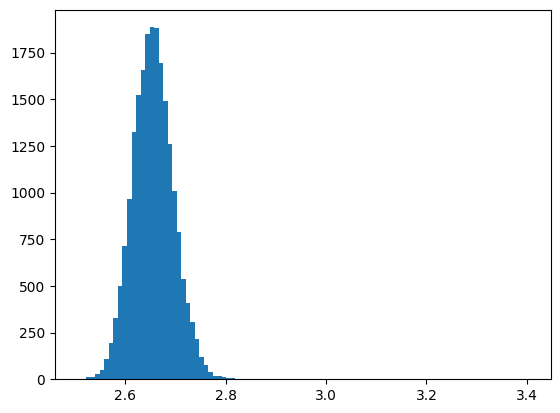

In [160]:
plt.hist(losses,bins=100)
plt.show()

In [161]:
descriptives(losses)

Mean:   2.65594354541071
SD:     0.04293488021500471
Median: 2.654503107070923
Min:    2.504870653152466
Max:    3.4028186798095703


In [162]:
idx = list(range(1,len(losses),25))

subset = [losses[i] for i in idx]

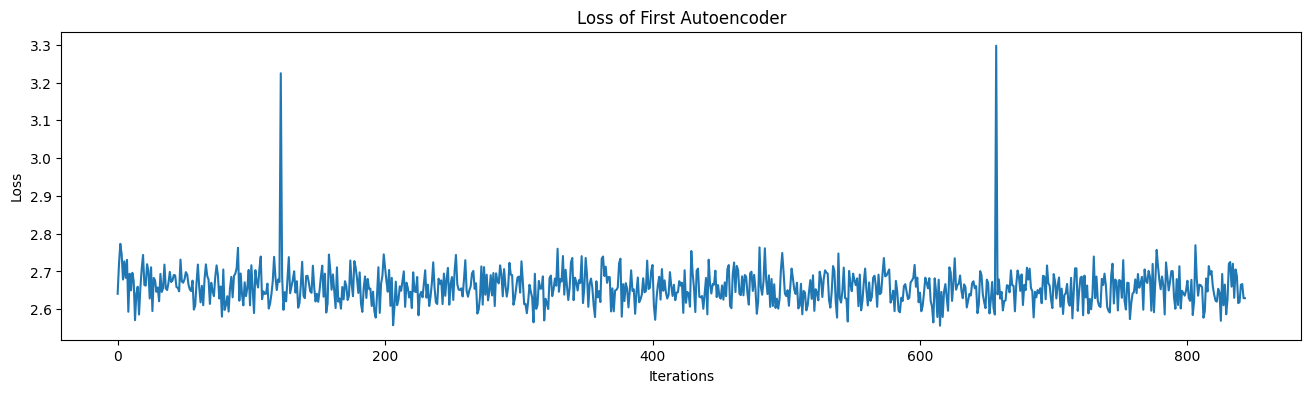

In [163]:
plt.figure(figsize=(16,4))
plt.plot(subset, label='Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss of First Autoencoder')
plt.show()

# __Random Forest Regressor__

In [ ]:
team1 = input("Enter Team 1:")
team2 = input("Enter Team 2:")

team1_df = df_teams[(df_teams['teamName'] == team1) & (df_teams['opponentTeamName'] == team2)]
team1_df

team2_df = df_teams[(df_teams['teamName'] == team2) & (df_teams['opponentTeamName'] == team1)]
team2_df

#model for team1
features = ['assists', 'blocks', 'steals', 'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersMade', 'freeThrowsMade', 'reboundsTotal', 'turnovers']
x = team1_df[features]
y = team1_df['teamScore']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

#model for team2
features2 = ['assists', 'blocks', 'steals', 'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersMade', 'freeThrowsMade', 'reboundsTotal', 'turnovers']
x = team2_df[features]
y = team2_df['teamScore']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(x_train, y_train)

In [ ]:
team1_score = team1_df[['assists', 'blocks', 'steals', 'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersMade', 'freeThrowsMade', 'reboundsTotal', 'turnovers']]
team2_score = team2_df[['assists', 'blocks', 'steals', 'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersMade', 'freeThrowsMade', 'reboundsTotal', 'turnovers']]

predicted_score1 = model.predict(team1_score)[0]
predicted_score2 = model2.predict(team2_score)[0]

print(f'{team1} Score: {predicted_score1}')
print(f'{team2} Score: {predicted_score2}')